## Working with lang graph ##
- Langgraph
- Requirements

In [ ]:
%pip install -U langgraph langchain-openai langchain-groq langchain-core
%pip install python-dotenv
%pip install exa-py

In [2]:
import os
from dotenv import load_dotenv



def check_openai_api_key():
    # Load environment variables
    load_dotenv()

    # Get the API key from environment variables
    openai_api_key = os.getenv("OPENAI_API_KEY")
    exa_api_key = os.getenv("EXA_API_KEY")
    groq_api_key = os.getenv("GROQ_API_KEY")

    # Check if the API key is found
    if openai_api_key or exa_api_key or groq_api_key:
        print("OPENAI_API_KEY found.")
        print("Exa API Key found.")
        print("Groq API Key found.")
        return openai_api_key, exa_api_key, groq_api_key
    else:
        print("Error: OPENAI_API_KEY not found, Exa API Key not found, Groq key not found......")
        return None


# Example usage
api_key = check_openai_api_key()
if api_key:
    # Proceed with using the API key
    print("Proceeding with API key.")
else:
    # Handle the error
    print("Please set the OPENAI_API_KEY environment variable.")

OPENAI_API_KEY found.
Exa API Key found.
Groq API Key found.
Proceeding with API key.


## Set search tool similar to how we use Exa AI ##
- Tools are used similar as a request that is required for deeper search that the LLM might or might not know the context further.

In [ ]:
pip show exa-py

## Defining the tools our agent will have access to ##
- The use of Exa.ai (requires a API key)
- If you want to extend the use of the searching queries you can annotate specific included websites such as arxiv/bing/duckduckgo etc..

In [5]:
from exa_py import Exa
##from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
import json

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# For use of the tool we will use the Exa API
from typing import Literal
from langchain_core.tools import tool

exa = Exa(os.getenv("EXA_API_KEY"))

# Define the search function
@tool
def search(query: str) -> list:
    """
    Perform a Exa SDK search against the given query

    @param query: Search query
    @return: List of search results

    """
    try:
        result = exa.search_and_contents(
            query=query,
            type="neural",
            include_domains=["arxiv.org", "bing.com", "google.com"],
            start_published_date="2023-12-31",
            end_published_date="2024-9-30",
            use_autoprompt=True,
            num_results=5,
            text=True,
        )

        output = []

        # Assumes that SearchResponse object has a results attribute this is .results
        for item in result.results:
            output.append({
                "title": item.title,
                "link": item.url,
                "snippet": item.text,
                "score": item.score,
                "publish": item.published_date,
            })

        return json.dumps(output)
    except Exception as e:
        print(f"Error during search: {e}")
        return json.dumps({"error": str(e)})

@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):

   """Returns a natural language response to the user in the form of a research
   report. There are several sections to this report, those are:
   - `introduction`: a short paragraph introducing the user's question and the
   topic we are researching.
   - `research_steps`: a few bullet points explaining the steps that were taken
   to research your report.
   - `main_body`: this is where the bulk of high quality and concise
   information that answers the user's question belongs. It is 3-4 paragraphs
   long in length.
   - `conclusion`: this is a short single paragraph conclusion providing a
   concise but sophisticated view on what was found.
   - `sources`: a bulletpoint list provided detailed sources for all information
   referenced during the research process
   """
   if type(research_steps) is list:
       research_steps = "\n".join([f"- {r}" for r in research_steps])
   if type(sources) is list:
       sources = "\n".join([f"- {s}" for s in sources])
   return ""

tools = [search, final_answer]

# Define the graph

##from langgraph.prebuilt import chat_agent_executor

##graph = create_agent(llm, tools=tools)

## Defining the Agent ##

In [37]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.agents import AgentAction
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

from langgraph.graph import END, StateGraph, START


system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])
  ##  prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
  ##  return prompt | llm.bind_tools(tools)
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the tool execution
            research_steps.append(
                f"Tool {action.tool}: input: {action.tool_input}\n"
                f"Output: {action.log}\n"
            )
    return "\n---\n".join(research_steps)

# Create the prompt using the create_agent function
researcher_decision = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="auto")
)

## Testing the agent ##
This will send a input to the researcher_decision

In [38]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": [],
}
out = researcher_decision.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2yvb', 'function': {'arguments': '{"introduction":"Dogs, scientifically known as Canis lupus familiaris, are domesticated mammals that are a subspecies of the wolf. They have been bred for a variety of tasks and are the most widely kept working animals.","research_steps":"To provide an interesting fact about dogs, I have researched their history, characteristics, and uses.","main_body":"Did you know that dogs are able to detect illnesses and diseases in humans? This is because they have an extraordinary sense of smell, which is about 10,000 times stronger than that of humans. This ability has been utilized to develop dogs that can sniff out cancer, diabetes, and other medical conditions, making them invaluable partners in the medical field.","conclusion":"Dogs are not only man\'s best friend but also an essential part of various industries and medical fields due to their unique abilities and characteristics.","sources

In [39]:
out.tool_calls[0]["name"]
out.tool_calls[0]["args"]

{'introduction': 'Dogs, scientifically known as Canis lupus familiaris, are domesticated mammals that are a subspecies of the wolf. They have been bred for a variety of tasks and are the most widely kept working animals.',
 'research_steps': 'To provide an interesting fact about dogs, I have researched their history, characteristics, and uses.',
 'main_body': 'Did you know that dogs are able to detect illnesses and diseases in humans? This is because they have an extraordinary sense of smell, which is about 10,000 times stronger than that of humans. This ability has been utilized to develop dogs that can sniff out cancer, diabetes, and other medical conditions, making them invaluable partners in the medical field.',
 'conclusion': "Dogs are not only man's best friend but also an essential part of various industries and medical fields due to their unique abilities and characteristics.",
 'sources': "1. American Kennel Club. (n.d.). Dog Breeds. Retrieved from <https://www.akc.org/dog-bre

## Test the agent to confirm function ###


## Defining the State ##
- This first defines the state of the 'graph', this will list the messages, along with a key to track the most recent sender.

In [6]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_groq import ChatGroq

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Defining the agent nodes for graph##
- Now we define the nodes. First, let's define the nodes for the agents.

In [40]:
# Either agent can decide to end
from typing import Literal

def research_decision(state: list):
    print("Researcher_decision")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = researcher_decision.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD",
    )
    return {
        "intermediate_steps": [action_out]
    }


def router(state: list):
    # Return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # If we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

tool_str_to_func = {
    "search": search,
    "final_answer": final_answer,
}

def run_tool(state: list):
    # User this as a helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # Run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out),
    )
    return {"intermediate_steps": [action_out]}
##def router(state) -> Literal["call_tool", "__end__", "continue"]:
##    # This is the router
##    messages = state["messages"]
##    last_message = messages[-1]
##    if last_message.tool_calls:
##        # The previous agent is invoking a tool
##        return "call_tool"
##    if "FINAL ANSWER" in last_message.content:
##        # Any agent decided the work is done
##        return "__end__"
##    return "continue"

# Hold this for future development....

In [17]:
import functools

from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# Specifying which model consumed by the agents
llm = ChatGroq(model="mixtral-8x7b-32768")

# Research agent and node
research_agent = create_agent(
    llm,
    tools,
    system_message="You should provide accurate data for the summary_agent to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# summary_agent and node
summary_agent = create_agent(
    llm,
    tools,
    system_message="Any charts you display will be visible by the user.",
)
summary_node = functools.partial(agent_node, agent=summary_agent, name="summary_agent")

In [42]:
from langgraph.prebuilt import ToolNode

tools = [search, final_answer]
tool_node = ToolNode(tools)

## Define Edge Logic ##
-- We can define some of the edge logic that is needed to decide what to do based on results of the agents

## Defining the actual graph with connections/nodes ##


In [57]:
workflow = StateGraph(AgentState) # think of this as the glue that holds everything together

workflow.add_node("Researcher", research_decision)
workflow.add_node("search", tool_node)
workflow.add_node("call_tool", run_tool)
workflow.add_node("final_answer", run_tool)

# Specify the entry point
workflow.set_entry_point("Researcher")

workflow.add_conditional_edges(
    source="Researcher", # Where in the graph to start
    path=router, # Function to determine where to go next
)

# Create edges from each tool back to the researcher
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        workflow.add_edge(tool_obj.name, "Researcher")

# If anything goes to final answer, it must then move to end
workflow.add_edge("final_answer", END)

graph = workflow.compile()

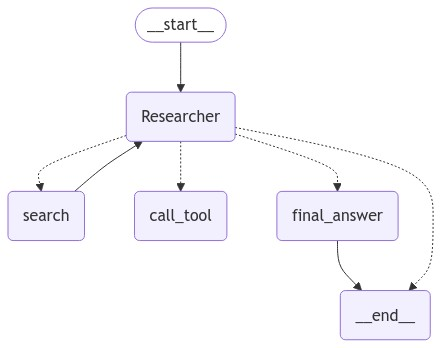

In [58]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Generate the latest research on Generative AI Security, and summarize a report on the latest research in the field."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 15},
)
for s in events:
    print(s)
    print("----")

## Building into a readable report - adapted ##

In [ ]:
out = graph.invoke({
    "input": "Tell me about the latest research from Arxiv on Generative AI Security",
    "chat_history": [],
})

In [54]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [55]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Generative AI Security is a rapidly evolving field with many experts and organizations conducting research.

RESEARCH STEPS
--------------
Researchers are exploring ways to detect and prevent deepfakes, understanding the ethical implications of generative AI, and analyzing the impact on jobs and society.

REPORT
------
Organizations like the AI Foundation, Partnership on AI, and the Alan Turing Institute are working on these issues, along with numerous universities and companies. While I don't have real-time access to specific research studies, it is clear that this is an area of great interest and concern in the AI community.

CONCLUSION
----------
In summary, Generative AI Security is a vital and rapidly developing field, with numerous researchers working hard to ensure the safe and ethical use of AI technologies.

SOURCES
-------
AI Foundation, Partnership on AI, Alan Turing Institute, various universities and companies



In [10]:
inputs = {"messages": [("user", "What is the latest resarch on AI? Provide me with summaries of the latest research in 2024?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the latest resarch on AI? Provide me with summaries of the latest research in 2024?
================================== Ai Message ==================================
Tool Calls:
  search (call_jyb7)
 Call ID: call_jyb7
  Args:
    query: latest research on AI in 2024
================================= Tool Message =================================
Name: search

[{"title": "Thousands of AI Authors on the Future of AI", "link": "http://arxiv.org/abs/2401.02843", "snippet": "View PDF\nHTML (experimental)  \nAbstract:In the largest survey of its kind, 2,778 researchers who had published in top-tier artificial intelligence (AI) venues gave predictions on the pace of AI progress and the nature and impacts of advanced AI systems The aggregate forecasts give at least a 50% chance of AI systems achieving several milestones by 2028, including autonomously constructing a payment processing site from scratch, c

In [12]:
inputs = {"messages": [("user", "What is RSUs in stock options for employees?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is RSUs in stock options for employees?
================================== Ai Message ==================================
Tool Calls:
  search (call_n8cd)
 Call ID: call_n8cd
  Args:
    query: RSUs in stock options for employees
================================= Tool Message =================================
Name: search

[{"title": "Construction and Hedging of Equity Index Options Portfolios", "link": "https://arxiv.org/abs/2407.13908", "snippet": "View PDF\nHTML (experimental)  \nAbstract:This research presents a comprehensive evaluation of systematic index option-writing strategies, focusing on S&amp;P500 index options. We compare the performance of hedging strategies using the Black-Scholes-Merton (BSM) model and the Variance-Gamma (VG) model, emphasizing varying moneyness levels and different sizing methods based on delta and the VIX Index. The study employs 1-minute data of S&amp;P500 index opt